In [38]:
import keras
from keras.models import load_model
from keras.datasets import cifar10
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from keras.models import load_model
import os
import pickle
import numpy as np
import skimage 

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
(x_train_noisy, y_train_noisy), (x_test_noisy, y_test_noisy) = cifar10.load_data()

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

x_val = x_test[:7000]
x_test = x_test[7000:]
model = load_model('denoise_autoencoder.h5')

In [39]:
def gaussian(image):
    num,row,col,ch= image.shape
    #print(image[1].shape)
    mean = 0
    var = 0.2
    sigma = var**0.5
    
    gauss = np.random.normal(mean,sigma,(num,row,col,ch))
    gauss.astype("float32")
    gauss = gauss.reshape(num,row,col,ch)
    #gauss=gauss.astype('uint8')
    y=image+0.2*gauss


    #noisy = image+gauss
    y= np.clip(y, 0, 255)
    #noisy = noisy.astype('uint8')
    #y=y.astype('uint8')
    return y

def s_p(image):
    num,row,col,ch = image.shape
    s_vs_p = 0.5
    amount = 0.06
    out = np.copy(image)
          # Salt mode
    num_salt = np.ceil(amount * image.size * s_vs_p)
    coords = [np.random.randint(0, i - 1, int(num_salt))
           for i in image.shape]

    out[coords] = 1

          # Pepper mode
    num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
    coords = [np.random.randint(0, i - 1, int(num_pepper))
                  for i in image.shape]
    out[coords] = 0


    #noisy = image+gauss
    y = np.clip(out, 0, 255)
    #noisy = noisy.astype('uint8')
    return y
    #image=image.astype('uint8')
    
def speckle(image):
    num,row,col,ch = image.shape
    gauss = np.random.randn(num,row,col,ch)
    gauss.astype("float32")
    gauss = gauss.reshape(num,row,col,ch)        
    noisy = image + image * gauss*0.1
    y = np.clip(noisy, 0, 255)
    return y

In [40]:
#t1, t2, t3= x_train[:16667],x_train[16667:33334],x_train[33334:]
s1, s2, s3= x_test[:1000],x_test[1000:2000],x_test[2000:]
v1, v2, v3= x_val[:2333],x_val[2333:4667],x_val[4667:]

#t1=gaussian(t1)
#t2=s_p(t2)
#t3=speckle(t3)
s1=gaussian(s1)
s2=s_p(s2)
s3=speckle(s3)
v1=gaussian(v1)
v2=s_p(v2)
v3=speckle(v3)

#t1=np.clip(t1, 0., 1.)
#t2=np.clip(t2, 0., 1.)
#t3=np.clip(t3, 0., 1.)
#t4=np.clip(t4, 0., 1.)
s1=np.clip(s1, 0., 1.)
s2=np.clip(s2, 0., 1.)
s3=np.clip(s3, 0., 1.)
#s4=np.clip(s4, 0., 1.)
v1=np.clip(v1, 0., 1.)
v2=np.clip(v2, 0., 1.)
v3=np.clip(v3, 0., 1.)
#v4=np.clip(v4, 0., 1.)

#x_train_noisy=np.concatenate([t1,t2,t3])
x_test_noisy=np.concatenate([s1,s2,s3])
x_val_noisy=np.concatenate([v1,v2,v3])

c:\users\user\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:31: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


In [41]:
c10test = model.predict(x_test_noisy)
c10val = model.predict(x_val_noisy)

In [53]:
def showOrigDec(orig, noise, denoise, num=10):
    import matplotlib.pyplot as plt
    import cv2
    n = num
    plt.figure(figsize=(20, 4))

    for i in range(n):
        # display original
        ax = plt.subplot(3, n, i+1)
        plt.imshow(orig[i].reshape(32, 32, 3))
        #orig[i]=orig[i].astype("uint8")
        plt.imsave("image"+str(i)+".png",orig[i])
        #plt.savefig("image"+str(i)+".png")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display noisy image
        ax = plt.subplot(3, n, i +1 + n)
        
        plt.imshow(noise[i].reshape(32, 32, 3))
        #noise[i]=noise[i].astype("uint8")
        plt.imsave("noise"+str(i)+".png",noise[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # display denoised image
        ax = plt.subplot(3, n, i +1 + n + n)
        plt.imshow(denoise[i].reshape(32, 32, 3))
        #denoise[i]=denoise[i].astype("uint8")
        plt.imsave("denoise"+str(i)+".png",denoise[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

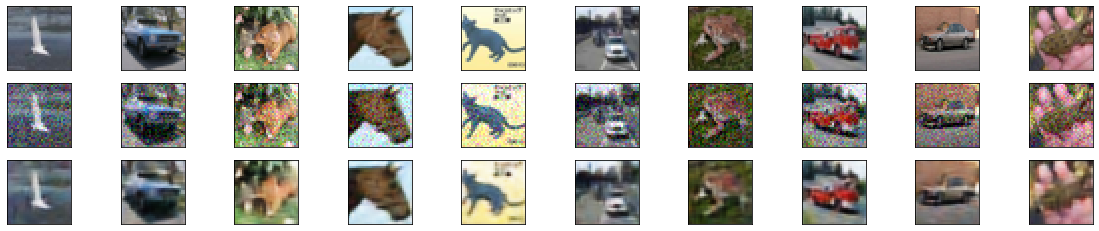

In [54]:
showOrigDec(x_test, x_test_noisy, c10test)

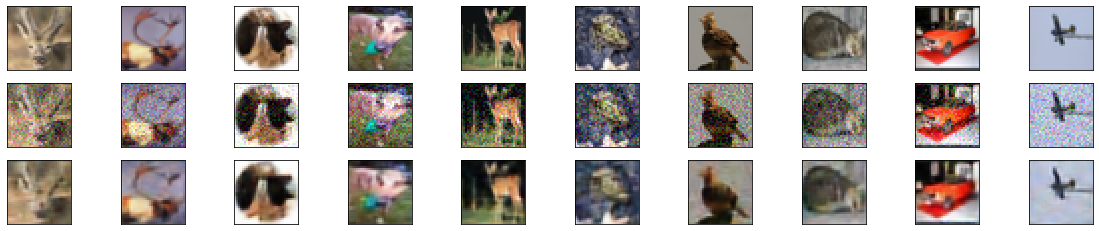

In [75]:
showOrigDec(x_test[200:], x_test_noisy[200:], c10test[200:])

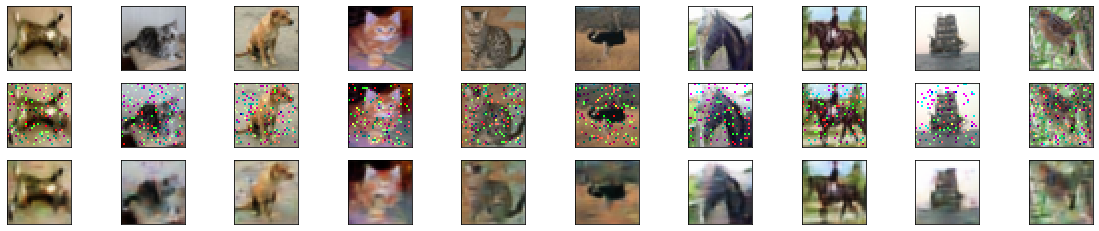

In [76]:
showOrigDec(x_test[1200:], x_test_noisy[1200:], c10test[1200:])

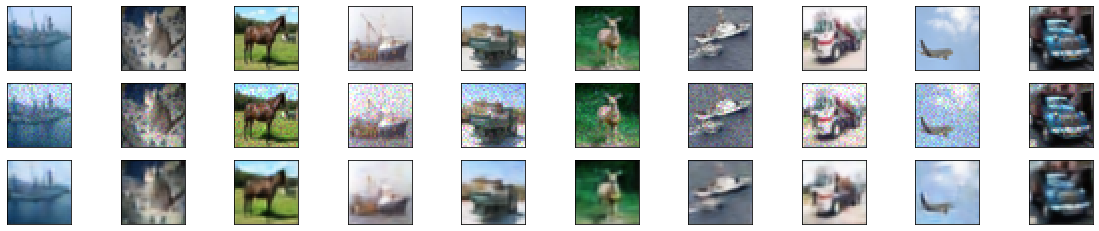

In [77]:
showOrigDec(x_test[2200:], x_test_noisy[2200:], c10test[2200:])

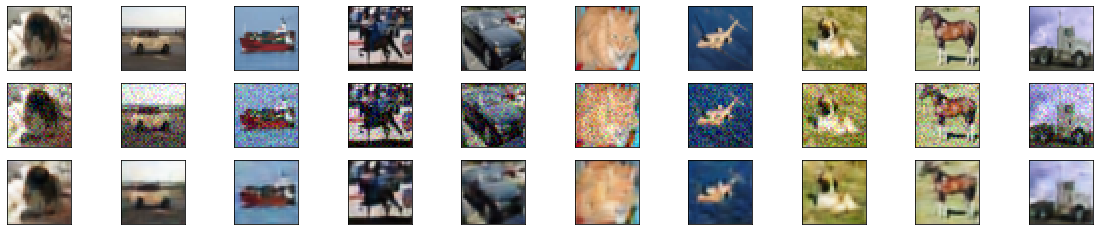

In [18]:
showOrigDec(x_val[200:], x_val_noisy[200:], c10val[200:])

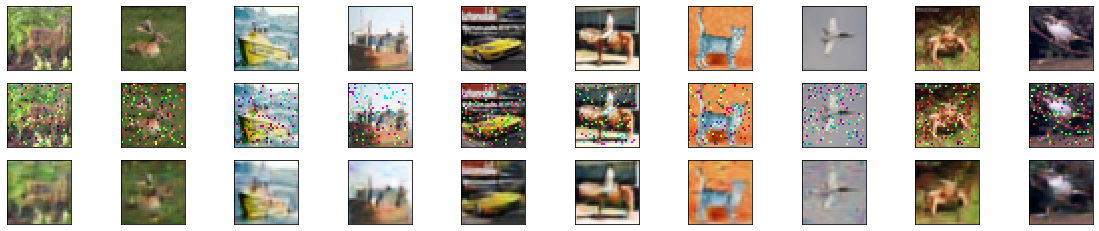

In [19]:
showOrigDec(x_val[2500:], x_val_noisy[2500:], c10val[2500:])

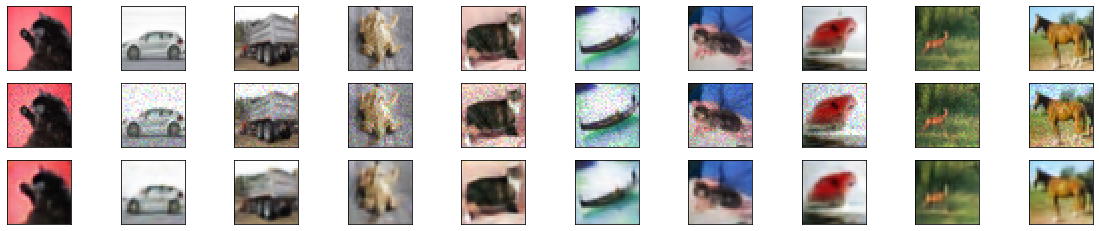

In [20]:
showOrigDec(x_val[5200:], x_val_noisy[5200:], c10val[5200:])

In [58]:
from skimage.measure import compare_ssim as ssim
def cal_ssim(orig, noise, denoise):
    val1=0
    val2=0
    for i in range(len(orig)):
        val1+=ssim(orig[i],denoise[i],multichannel=True)
        val2+=ssim(orig[i],noise[i],multichannel=True)
    val1/=len(orig)
    val2/=len(orig)
    
    return val1, val2

In [59]:
ssim1, ssim2= cal_ssim(x_test[:10], x_test_noisy[:10], c10test[:10])
print("Gaussian : ssim between original and denoised image = "+str(ssim1)+" between original and noisy image= "+str(ssim2))

Gaussian : ssim between original and denoised image = 0.9039507992258289 between original and noisy image= 0.7679352848869844


c:\users\user\appdata\local\programs\python\python37\lib\site-packages\skimage\measure\_structural_similarity.py:155: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "


In [60]:
ssim1, ssim2= cal_ssim(x_test[1000:1010], x_test_noisy[1000:1010], c10test[1000:1010])
print("Salt and pepper : ssim between original and denoised image = "+str(ssim1)+" between original and noisy image= "+str(ssim2))

Salt and pepper : ssim between original and denoised image = 0.8898289999600996 between original and noisy image= 0.7187237395873595


In [61]:
ssim1, ssim2= cal_ssim(x_test[2000:2010], x_test_noisy[2000:2010], c10test[2000:2010])
print("Speckle : ssim between original and denoised image = "+str(ssim1)+" between original and noisy image= "+str(ssim2))

Speckle : ssim between original and denoised image = 0.9299215993004548 between original and noisy image= 0.8956680462364333


In [70]:
import math
def rmse(T1, T2, T3):
    err1=0
    err2=0
    for i in range(len(T1)):
        x=np.sum((T1[i]-T2[i])**2)
        err=x
        err= round(np.sqrt(err/float(T1[i].shape[0] * T1[i].shape[1]*3)),10)
        err1+=err
        x=np.sum((T1[i]-T3[i])**2)
        err=x
        err= round(np.sqrt(err/float(T1[i].shape[0] * T1[i].shape[1]*3)),10)
        err2+=err
    err1/=len(T1)
    err2/=len(T1)
    return err2, err1

def pnsr(img1, img2, img3):
    err1=0
    err2=0
    for i in range(len(img1)):
        mse = np.mean( (img1[i] - img2[i]) ** 2 )
        if mse == 0:
            err=100
        PIXEL_MAX = 255.0
        err=round(20 * math.log10(PIXEL_MAX / math.sqrt(mse)),10)
        err1+=err
        mse = np.mean( (img1[i] - img3[i]) ** 2 )
        if mse == 0:
            err=100
        PIXEL_MAX = 255.0
        err=round(20 * math.log10(PIXEL_MAX / math.sqrt(mse)),10)
        err2+=err
    return err2, err1
        

rmse1, rmse2= rmse(x_test[:10], x_test_noisy[:10], c10test[:10])
print("Gaussian : rmse between original and denoised image = "+str(rmse1)+" between original and noisy image= "+str(rmse2))

In [74]:
rmse1, rmse2= rmse(x_test[:10], x_test_noisy[:10], c10test[:10])
print("Gaussian : rmse between original and denoised image = "+str(rmse1)+" between original and noisy image= "+str(rmse2))

Gaussian : rmse between original and denoised image = 0.0540799723 between original and noisy image= 0.08656051658


In [64]:
rmse1, rmse2= rmse(x_test[1000:1010], x_test_noisy[1000:1010], c10test[1000:1010])
print("Salt and pepper : rmse between original and denoised image = "+str(rmse1)+" between original and noisy image= "+str(rmse2))

Salt and pepper : rmse between original and denoised image = 0.06120604024 between original and noisy image= 0.13698281767


In [65]:
rmse1, rmse2= rmse(x_test[2000:2010], x_test_noisy[2000:2010], c10test[2000:2010])
print("Speckle : rmse between original and denoised image = "+str(rmse1)+" between original and noisy image= "+str(rmse2))

Speckle : rmse between original and denoised image = 0.044692003730000006 between original and noisy image= 0.04866116012


In [71]:
psnr1, psnr2= pnsr(x_test[:10], x_test_noisy[:10], c10test[:10])
print("Gaussian : psnr between original and denoised image = "+str(psnr1)+" between original and noisy image= "+str(psnr2))

Gaussian : psnr between original and denoised image = 736.1046640520001 between original and noisy image= 693.8758312845


In [72]:
psnr1, psnr2= pnsr(x_test[1000:1010], x_test_noisy[1000:1010], c10test[1000:1010])
print("Salt and pepper : psnr between original and denoised image = "+str(psnr1)+" between original and noisy image= "+str(psnr2))

Salt and pepper : psnr between original and denoised image = 724.7044004830001 between original and noisy image= 654.0904626515999


In [73]:
psnr1, psnr2= pnsr(x_test[2000:2010], x_test_noisy[2000:2010], c10test[2000:2010])
print("Speckle : psnr between original and denoised image = "+str(psnr1)+" between original and noisy image= "+str(psnr2))

Speckle : psnr between original and denoised image = 751.9642024333999 between original and noisy image= 745.4086234599001
